In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

print(os.getcwd())

/home/seonwoo0808/NET-Zero


In [2]:
import sentencepiece
import tensorflow as tf
import transformers 
from transformers import TFBertModel
from sklearn.model_selection import train_test_split
# MIN MAX SCALING
from sklearn.preprocessing import MinMaxScaler

from kobert_tokenizer import KoBERTTokenizer

2025-06-25 18:09:24.284982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750874964.301520   68503 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750874964.306617   68503 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750874964.320148   68503 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750874964.320160   68503 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750874964.320162   68503 computation_placer.cc:177] computation placer alr

In [3]:
df = pd.read_csv('./data/SFTlabel_with_distances.csv') 

# drop unnecessary columns
df = df.drop(columns=['contents', 'gpt4o_answer', 'gpt4o_mini_answer'])
df.head()

,question,origin_gpt4o_distance,origin_gpt4o_mini_distance
0,구름을 보고 느끼는 감정에 대한 주제로 시를 써줘.,1.151845,1.176787
1,"산림의 주요 기능은 무엇이며, 환경 보호와 관련하여 어떤 역할을 하나요?",0.902078,0.866451
2,화학 반응에서 열역학 법칙은 어떻게 적용되며 어떤 예제가 있나요?,1.117957,1.068622
3,유리공예 작업할 때 필요한 도구와 재료가 뭐야?,0.953836,0.814288
4,산맥에서 어떤 종류의 동식물이 발견될까요?,1.151274,0.983507


In [4]:
X_raw = df['question']
y1 = df['origin_gpt4o_distance'].to_numpy()
y2 = df['origin_gpt4o_mini_distance'].to_numpy()

print(np.max(y1), np.max(y2), np.mean(y1), np.mean(y2), np.min(y1), np.min(y2))

length = len(y1)

y_in_row = np.append(y1, y2).reshape(length*2)
print(y_in_row.shape)

# Min-Max Scaling
scaler = MinMaxScaler()
result = scaler.fit_transform(y_in_row.reshape(-1, 1))
y1 = result[:length]
y2 = result[length:]

diff = y1 - y2
print(np.max(diff), np.mean(diff), np.min(diff))

print(X_raw.shape, y1.shape, y2.shape)

y = np.column_stack((y1, y2))



1.4054266161083642 1.407758604760598 0.9460541281817556 0.9001182491872406 0.5119266437650143 0.4581584214480576
(2596,)
0.5390429862386011 0.04837391546648035 -0.36597151768720304
(1298,) (1298, 1) (1298, 1)


In [5]:
# Load KoBERT tokenizer
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

X_tokenized = tokenizer(
    X_raw.tolist(),
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='np',
)

# make 3D tensor
X_id = X_tokenized['input_ids'] # (10000, 128)
X_mask = X_tokenized['attention_mask'] # (10000, 128)

print(X_id[0], X_mask[0])
# (10000,2, 128)
X = np.stack([X_id, X_mask], axis=1) # (10000, 2, 128)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


[   2 1115 6117 7088 2358 1546 5760  803 6896 1682 4240 2959 6116 3080
 7303   54    3    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [6]:
X.shape, y.shape

((1298, 2, 128), (1298, 2))

In [7]:
X

array([[[   2, 1115, 6117, ...,    1,    1,    1],
        [   1,    1,    1, ...,    0,    0,    0]],

       [[   2, 2640, 6136, ...,    1,    1,    1],
        [   1,    1,    1, ...,    0,    0,    0]],

       [[   2, 5123, 2217, ...,    1,    1,    1],
        [   1,    1,    1, ...,    0,    0,    0]],

       ...,

       [[   2, 2704, 6241, ...,    1,    1,    1],
        [   1,    1,    1, ...,    0,    0,    0]],

       [[   2, 4015, 7178, ...,    1,    1,    1],
        [   1,    1,    1, ...,    0,    0,    0]],

       [[   2, 3447, 6903, ...,    1,    1,    1],
        [   1,    1,    1, ...,    0,    0,    0]]])

In [8]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
train_X[0].shape, train_y[0].shape

((2, 128), (2,))

In [9]:
# Bquilding the model
class KoBertModel(tf.keras.Model):
    def __init__(self, num_classes=2):
        super(KoBertModel, self).__init__()
        self.bert = TFBertModel.from_pretrained('skt/kobert-base-v1')
        self.dropout1 = tf.keras.layers.Dropout(0.2)
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dropout2 = tf.keras.layers.Dropout(0.2)
        self.dense2 = tf.keras.layers.Dense(num_classes, activation='sigmoid',)

    def call(self, inputs):
        input_ids, attention_mask = inputs[:, 0], inputs[:, 1]
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # [CLS] token representation
        x = self.dropout1(pooled_output)
        x = self.dense1(x)
        x = self.dropout2(x)
        x = self.dense2(x)
        return x

In [10]:
model = KoBertModel(num_classes=2)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])



I0000 00:00:1750874969.427366   68503 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22329 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0b:00.0, compute capability: 8.6
All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [11]:
model(train_X[0:1], training=False)  # 모델을 초기화하기 위해 한 번 호출

model.summary()

Model: "ko_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model (TFBertModel  multiple                  92186880  
 )                                                               
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 dense (Dense)               multiple                  98432     
                                                                 
 dropout_38 (Dropout)        multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  258       
                                                                 
Total params: 92285570 (352.04 MB)
Trainable params: 92285570 (352.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    x=train_X,
    y=train_y,
    validation_data=(test_X, test_y),
    epochs=50,
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50


I0000 00:00:1750874987.621471   68616 service.cc:152] XLA service 0x7b9a6d418ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750874987.621491   68616 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-06-25 18:09:47.627132: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750874987.642715   68616 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750874987.718065   68616 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 [==============================] - 41s 461ms/step - loss: 0.0370 - mean_absolute_error: 0.1539 - val_loss: 0.0324 - val_mean_absolute_error: 0.1417
Epoch 2/50
17/17 [==============================] - 6s 341ms/step - loss: 0.0307 - mean_absolute_error: 0.1374 - val_loss: 0.0289 - val_mean_absolute_error: 0.1364
Epoch 3/50
17/17 [==============================] - 6s 341ms/step - loss: 0.0278 - mean_absolute_error: 0.1326 - val_loss: 0.0271 - val_mean_absolute_error: 0.1329
Epoch 4/50
17/17 [==============================] - 6s 341ms/step - loss: 0.0268 - mean_absolute_error: 0.1300 - val_loss: 0.0255 - val_mean_absolute_error: 0.1292
Epoch 5/50
17/17 [==============================] - 6s 335ms/step - loss: 0.0248 - mean_absolute_error: 0.1260 - val_loss: 0.0263 - val_mean_absolute_error: 0.1303
Epoch 6/50
17/17 [==============================] - 6s 342ms/step - loss: 0.0239 - mean_absolute_error: 0.1229 - val_loss: 0.0239 - val_mean_absolute_error: 0.1248
Epoch 7/50
17/17 [========

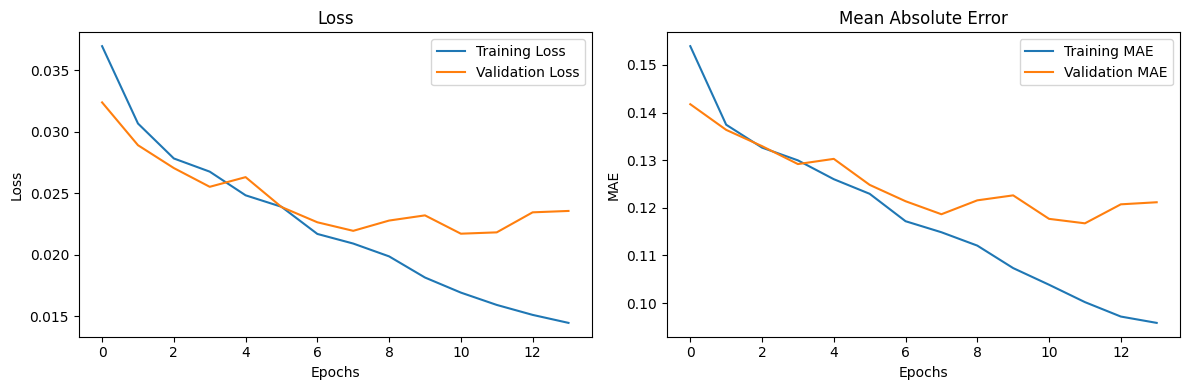

In [13]:
# save the model
model.save_weights('./kobert_model_weights.h5')

# visualize the training history
import matplotlib.pyplot as plt
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.title('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [14]:
# Save model with SavedModel format for TensorFlow Serving
tf.keras.models.save_model(model, './kobert_model', save_format='tf')

INFO:tensorflow:Assets written to: ./kobert_model/assets


INFO:tensorflow:Assets written to: ./kobert_model/assets
